In [1]:
import game_play_rule as game
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import doctest
import game_strategies as stra

In [2]:
#check if the bid is valid
def valid_bid(bids):
    """
    Check if the bid sequence is valid: at least one of quantity or face_value
    increases in every step.

    :param bids: List of bids, where each bid is [quantity, face_value].
    :return: True if all bids are valid, False otherwise.
    >>> bids = [[4, 1], [4, 2], [10, 5], [14, 5], [16, 4], [18, 4], [19, 4]]
    >>> valid_bid(bids)
    True
    >>> bids = [[4, 1], [4, 2], [10, 5], [9, 5], [16, 4], [18, 4], [19, 4]]
    >>> valid_bid(bids)
    False
    """
    is_increasing = True  
    for i in range(1, len(bids)):
        prev_quantity, prev_face_value = bids[i - 1]
        curr_quantity, curr_face_value = bids[i]
        if not (curr_quantity > prev_quantity or curr_face_value > prev_face_value):
            is_increasing = False
            break
    return is_increasing
doctest.testmod()

TestResults(failed=0, attempted=4)

In [3]:
class Validation_varaibales:
    """
    A class to manage and validate game statistics, such as player results, dice distributions, liar call outcomes, and bid records.

    """
    def __init__(self,num_players,num_dices,times):
        """
        Initialize the validation variables.

        :param num_players: Number of players in the game.
        :param num_dices: Number of dice each player has.
        :param times: Number of game iterations to simulate.
        """
        self.num_players = num_players
        self.num_dices = num_dices
        self.times = times
        self.results = {}
        self.first_players = {}
        for i in range(num_players):
            self.results[f"player{i}"] = 0
            self.first_players[f'player {i}'] = 0
        self.original = {key: 0 for key in range(1, 7)}
        self.liar_player = {key :0 for key in range(num_players)}
        quantity = list(range(1, (num_players * num_dices) + 1)) 
        face_value = list(range(1, 7))
        data = [(q, f, 0, 0, 0) for q in quantity for f in face_value]
        self.liar_occur_bid = pd.DataFrame(data,columns = ['quantity','face_value','times','valid_times','invalid_times'])
        self.liar_result = {"valid":0, "invalid" :0}
        

    def update(self,winner, first_player, bid_record, liar_record, bid_times, original_dices):
        """
        Update the validation variables after each game iteration.
        Check if the bid is valid

        :param winner: The index of the player who won the game.
        :param first_player: The index of the player who started the game.
        :param bid_record: A record of all bids made during the game.
        :param liar_record: A record of all liar calls made during the game.
        :param bid_times: The total number of bids in the game.
        :param original_dices: A dictionary of dice face value distributions for the game.
        """
        for bid in bid_record:
            bids = []
            for player, action in bid.items():
                if action == 'liar':
                    if valid_bid(bids):
                        pass 
                    else:
                        print("There are invalid bid exists")
                        break
                else:
                    bids.append(action)
    
        #record the winner and the first player distribution
        self.results[f"player{winner}"] += 1
        self.first_players[f"player {first_player}"] += 1
        
        #record the original dice distribution
        for key, values in original_dices.items():
            self.original[key] += values
    
        #record the liar call results
        for i in range(len(liar_record)):
            bid_times,current_player,challenge_bid,result,active_players = liar_record[i]
            if result == "valid":
                self.liar_result['valid']  += 1 
            else:
                self.liar_result['invalid'] += 1
            self.liar_player[current_player] += 1
            quantity, face_value = challenge_bid
            index = self.liar_occur_bid[(self.liar_occur_bid['quantity'] == quantity) & (self.liar_occur_bid['face_value'] == face_value)].index
            self.liar_occur_bid.loc[index,'times'] += 1
            if result == "valid":
                self.liar_occur_bid.loc[index,'valid_times'] += 1 
            else:
                self.liar_occur_bid.loc[index,'invalid_times'] += 1

    
    def check_original_dices(self):
        """
        Analyze and display the dice face value distribution across all games.
        Check whether the original dice values are random.
        """
        df = pd.DataFrame(list(self.original.items()), columns=["Face_value", "Occurrence"])
        df['Occurrence rate'] = df['Occurrence'] / (self.times * self.num_players * self.num_dices)
        df["Occurrence rate"] = df["Occurrence rate"].apply(lambda x: f"{x:.2%}") 
        print(df)


    def check_win_rate(self):
        """
        Analyze and display the win rate for each player.
        Check whether the win rate of each player is equal.
        """
        win_rate_df = pd.DataFrame(list(self.results.items()), columns=["Player", "Wins"])
        win_rate_df['Win Rate'] = win_rate_df['Wins'] / self.times
        win_rate_df["Win Rate"] = win_rate_df["Win Rate"].apply(lambda x: f"{x:.2%}") 
        print(win_rate_df)


    def check_first_player(self):
        """
        Analyze and display the distribution of first players across games.
        Check if the first player is random.
        """
        start_rate_df = pd.DataFrame(list(self.first_players.items()), columns=["Player", "Start times"])
        start_rate_df['Start rate'] = start_rate_df['Start times'] / self.times
        start_rate_df["Start rate"] = start_rate_df["Start rate"].apply(lambda x: f"{x:.2%}") 
        print(start_rate_df)

    def check_liar_call(self):
        """
        Analyze and visualize the distribution of liar calls.
        Check if the liar calsl are random

        Generates a heatmap of challenge bids based on the proportion of quantity(quantity / total_dice) and face value.
        """
        # Add a new column for quantity proportion
        #TODO
        self.liar_occur_bid = self.liar_occur_bid.sort_values(by='times', ascending=False)
        print(self.liar_occur_bid)
        #draw the heatmap of challenge_bid 
        pivot_table = self.liar_occur_bid.pivot(index='face_value', columns='quantity', values='times')
        sns.heatmap(pivot_table, annot=False, fmt="d", cmap="coolwarm", cbar=True)
        plt.title("Heatmap of Quantity vs Face Value")
        plt.xlabel("Quantity")
        plt.ylabel("Face Value")
        plt.show()

    def check_liar_valid_rate(self):
        """
        Analyze the relationship between bid quantity and liar call validity rate.

        """
        #check if with the quantity rasies, the valid rate increases,
        #need to exclude the maxmum quantity matching the max_dices
        grouped_liar = self.liar_occur_bid.groupby('quantity').agg({'times':'sum', 'valid_times':'sum', 'invalid_times':'sum'})
        grouped_liar['valid_rate'] = grouped_liar['valid_times'] / grouped_liar['times']
        grouped_liar
        plt.figure(figsize=(8, 6))
        plt.plot(grouped_liar.index, grouped_liar['valid_rate'], marker='o', label='Valid Rate')
        plt.title("Valid Rate across Quantity")
        plt.xlabel("Quantity")
        plt.ylabel("Valid Rate")
        plt.ylim(0, 1)  # Valid rate is a ratio (0 to 1)
        plt.grid(True)
        plt.legend()
        plt.show()

## Validation for the random stragegies
This script simulates a dice game involving 5 players, where each player starts with 5 dice and employs random strategies. The goal is to validate various aspects of the game under random conditions, such as distribution of dice rolls, win rates, and "liar" call patterns, without adopting any specific strategic behavior.
### Purpose of the Simulation
#### Establish Baselines:
This simulation provides a baseline for analyzing game dynamics under random strategies.
#### Test Randomness:
Check if dice rolls follow a uniform distribution.
Verify if the starting player selection is random.
Ensure no bias exists in win rates when using random strategies.
#### Analyze "Liar" Calls:
Identify patterns in "liar" calls, including their frequency and validity.
Explore relationships between bid size, dice count, and call validity.


In [4]:
# Simulate the game with 5 players and each player has 5 dices(everyone uses random strategies)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice,Strategies)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4191          16.76%
1           2        4169          16.68%
2           3        4207          16.83%
3           4        4132          16.53%
4           5        4107          16.43%
5           6        4194          16.78%



win rate distribution
    Player  Wins Win Rate
0  player0   191   19.10%
1  player1   212   21.20%
2  player2   206   20.60%
3  player3   189   18.90%
4  player4   202   20.20%



first player distribution
     Player  Start times Start rate
0  player 0          196     19.60%
1  player 1          198     19.80%
2  player 2          195     19.50%
3  player 3          222     22.20%
4  player 4          189     18.90%



challenge bid distribution
     quantity  face_value  times  valid_times  invalid_times
59         10           6    140          136              4
89         15           6     88           88              0
17          3           6     82            9    

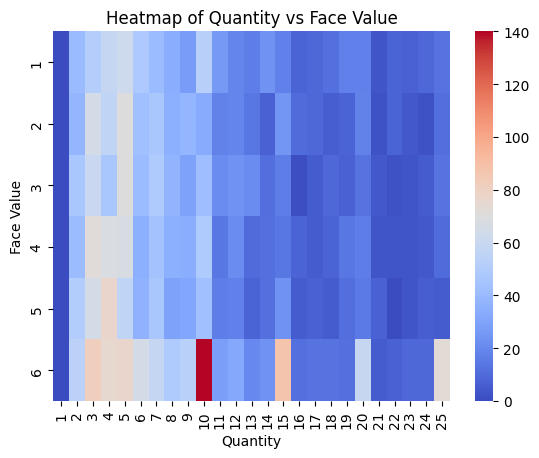




liar valid rate


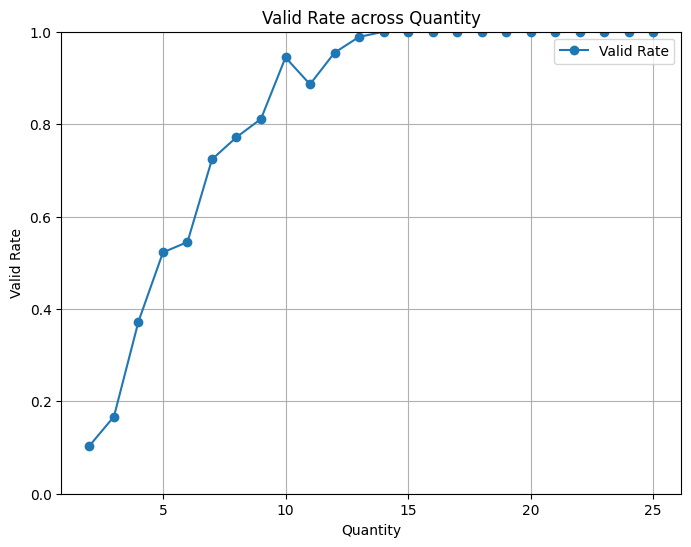

In [5]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### 1. Test for the First-Caller Hypothesis:

The First-Caller Advantage Hypothesis suggests that when the probability distribution of dice combinations aligns with statistical expectations, the player who initiates the bidding (the first caller) tends to have a higher win rate compared to their opponents.

In [6]:
# Simulate the game with 5 players and each player has 5 dice (everyone uses random strategies,but the first player always bid first)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = 0)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4150          16.60%
1           2        4190          16.76%
2           3        4118          16.47%
3           4        4139          16.56%
4           5        4173          16.69%
5           6        4230          16.92%



win rate distribution
    Player  Wins Win Rate
0  player0   201   20.10%
1  player1   121   12.10%
2  player2   186   18.60%
3  player3   218   21.80%
4  player4   274   27.40%



first player distribution
     Player  Start times Start rate
0  player 0         1000    100.00%
1  player 1            0      0.00%
2  player 2            0      0.00%
3  player 3            0      0.00%
4  player 4            0      0.00%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
59        10           6    138          132              6
89        15           6     87           87              0
17         3           6     77            9        

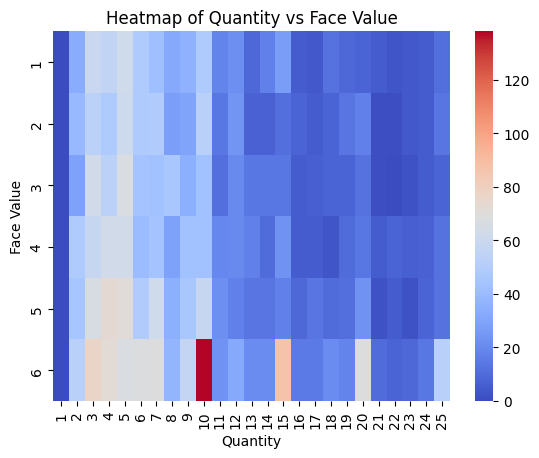




liar valid rate


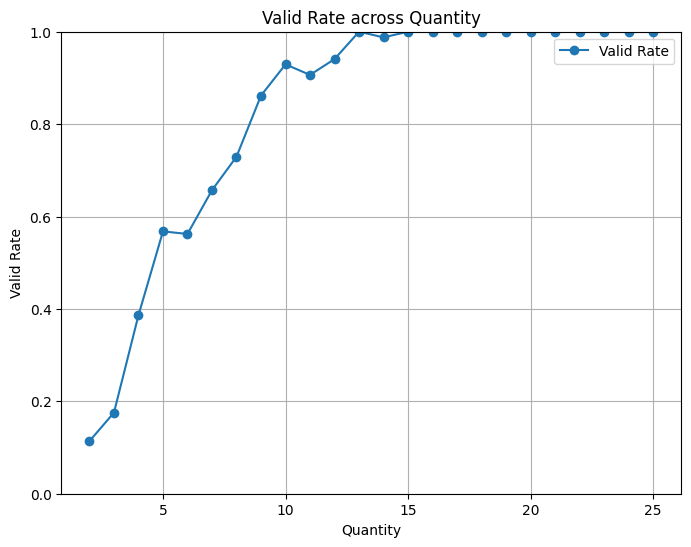

In [7]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### 2. Test Hypothesis for Threshold-Based Strategy

The Threshold-Based Call Hypothesis suggests that, under typical game rules, the player employing a threshold-based strategy (e.g., always calling "liar" when the opponent's bid exceeds half the total dice count of any face value) will have a higher success rate compared to players using purely random strategies.

This hypothesis examines whether such a strategy gives the player a measurable advantage over opponents.

In [8]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses normal_threshold strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(normal_threshold = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4176          16.70%
1           2        4187          16.75%
2           3        4291          17.16%
3           4        4151          16.60%
4           5        4035          16.14%
5           6        4160          16.64%



win rate distribution
    Player  Wins Win Rate
0  player0   335   33.50%
1  player1   158   15.80%
2  player2   162   16.20%
3  player3   172   17.20%
4  player4   173   17.30%



first player distribution
     Player  Start times Start rate
0  player 0          175     17.50%
1  player 1          219     21.90%
2  player 2          216     21.60%
3  player 3          189     18.90%
4  player 4          201     20.10%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
59        10           6    118          110              8
41         7           6     77           53             24
29         5           6     73           39        

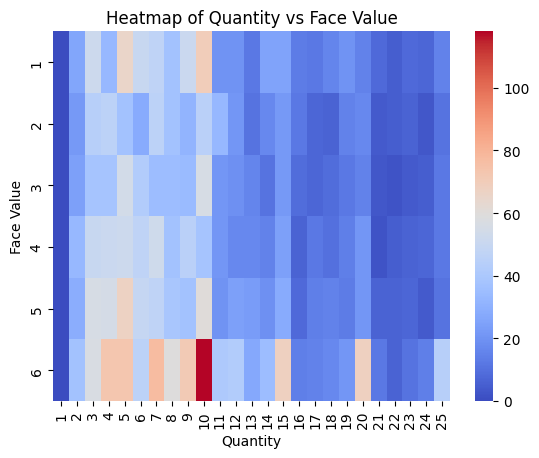




liar valid rate


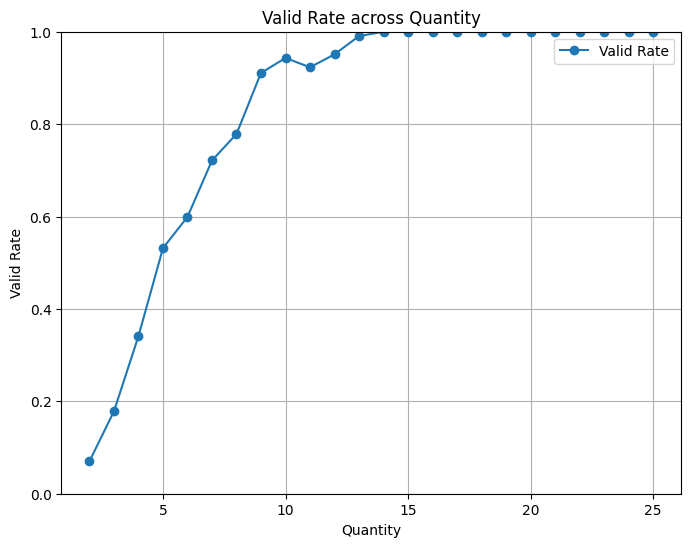

In [9]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### 3. Test Hypothesis for Prefer-Bid Strategy
The Prefer-Bid Hypothesis suggests that a player who prioritizes bidding using the face value of the dice they hold in the highest quantity will outperform opponents using random strategies. This hypothesis assumes that leveraging personal dice knowledge provides a statistical advantage in the game.

In [10]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses prefer_bid strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(prefer_bid = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4187          16.75%
1           2        4151          16.60%
2           3        4229          16.92%
3           4        4034          16.14%
4           5        4252          17.01%
5           6        4147          16.59%



win rate distribution
    Player  Wins Win Rate
0  player0   305   30.50%
1  player1   179   17.90%
2  player2   154   15.40%
3  player3   188   18.80%
4  player4   174   17.40%



first player distribution
     Player  Start times Start rate
0  player 0          214     21.40%
1  player 1          186     18.60%
2  player 2          224     22.40%
3  player 3          196     19.60%
4  player 4          180     18.00%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
59        10           6    103           96              7
26         5           3     79           34             45
19         4           2     77           19        

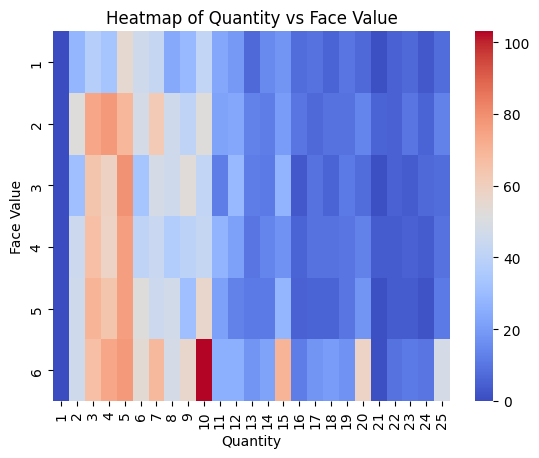




liar valid rate


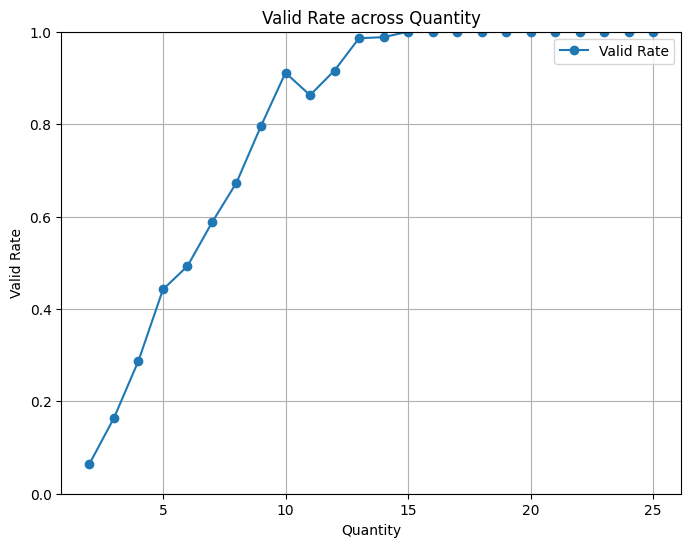

In [11]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### 4. Test for Optimal-Threshold Strategy Hypothesis

The Optimal-Threshold Hypothesis suggests that a player who calls "liar" based on an optimal threshold derived from their own dice count and statistical expectations of the remaining dice will outperform opponents using random strategies. This strategy calculates a dynamic threshold to decide whether to challenge a bid, potentially increasing the success rate of "liar" calls.

In [12]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses optimal_threshold strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(optimal_threshold = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4162          16.65%
1           2        4117          16.47%
2           3        4199          16.80%
3           4        4043          16.17%
4           5        4131          16.52%
5           6        4348          17.39%



win rate distribution
    Player  Wins Win Rate
0  player0   390   39.00%
1  player1   153   15.30%
2  player2   150   15.00%
3  player3   137   13.70%
4  player4   170   17.00%



first player distribution
     Player  Start times Start rate
0  player 0          199     19.90%
1  player 1          235     23.50%
2  player 2          204     20.40%
3  player 3          167     16.70%
4  player 4          195     19.50%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
59        10           6    105          104              1
23         4           6     81           23             58
29         5           6     79           40        

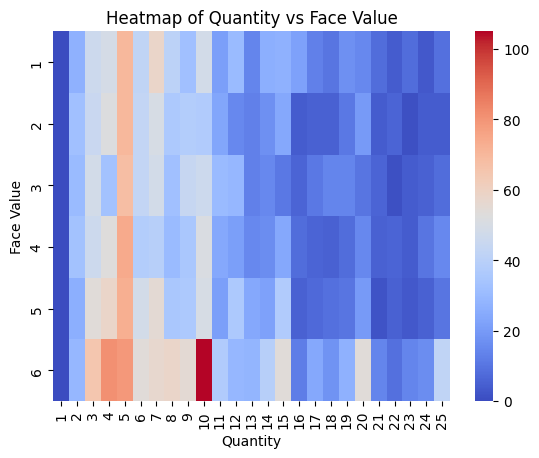




liar valid rate


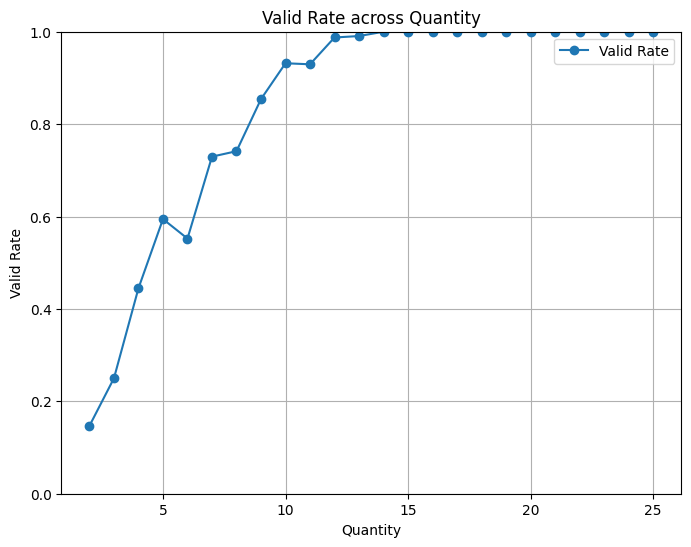

In [13]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### 5. Test for prefer_bid combinging normal_threshold Strategy
The Combined Prefer-Bid and Normal-Threshold Hypothesis suggests that a player who use prefer_bid strategy and normal_threshold strategy at the same time will achieve a higher success rate compared to opponents using only random strategies. This combined strategy leverages personal dice knowledge for bidding and a statistical threshold for challenging.

In [14]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses normal_threshold and prefer_bid strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(normal_threshold = True,prefer_bid = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4280          17.12%
1           2        4106          16.42%
2           3        4145          16.58%
3           4        4143          16.57%
4           5        4120          16.48%
5           6        4206          16.82%



win rate distribution
    Player  Wins Win Rate
0  player0   524   52.40%
1  player1   102   10.20%
2  player2   132   13.20%
3  player3   110   11.00%
4  player4   132   13.20%



first player distribution
     Player  Start times Start rate
0  player 0          192     19.20%
1  player 1          192     19.20%
2  player 2          198     19.80%
3  player 3          218     21.80%
4  player 4          200     20.00%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
25         5           2     83           30             53
59        10           6     80           76              4
29         5           6     70           26        

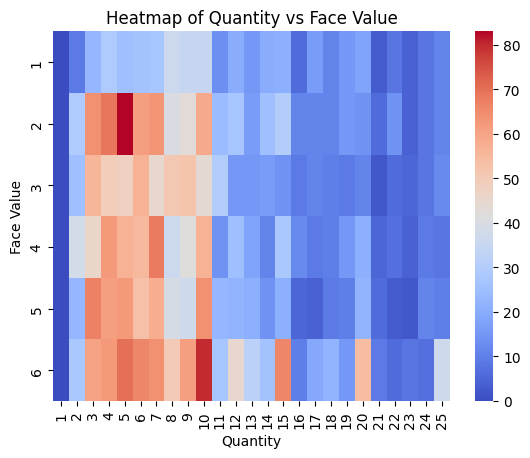




liar valid rate


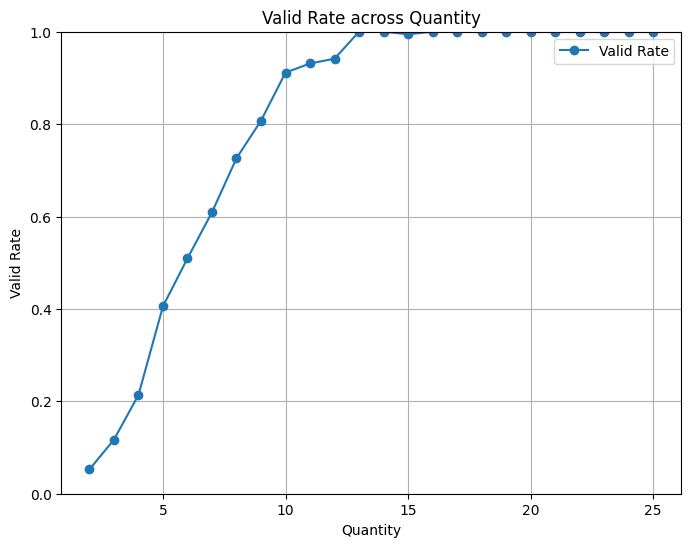

In [15]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### 6. Test for Conservative Increase Strategy
The Conservative Increase Hypothesis posits that a player who adopts a strategy of only incrementing the bid quantity by 1 per turn, rather than making larger or random increases, will achieve a higher success rate in the game. This approach reduces risk while maintaining competitive bids, potentially leading to a more consistent game outcome.

In [16]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses conservative_increase strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(conservative_increase = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4072          16.29%
1           2        4214          16.86%
2           3        4260          17.04%
3           4        4147          16.59%
4           5        4062          16.25%
5           6        4245          16.98%



win rate distribution
    Player  Wins Win Rate
0  player0   215   21.50%
1  player1   191   19.10%
2  player2   214   21.40%
3  player3   190   19.00%
4  player4   190   19.00%



first player distribution
     Player  Start times Start rate
0  player 0          191     19.10%
1  player 1          177     17.70%
2  player 2          216     21.60%
3  player 3          202     20.20%
4  player 4          214     21.40%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
59        10           6    124          118              6
29         5           6     92           42             50
23         4           6     84           19        

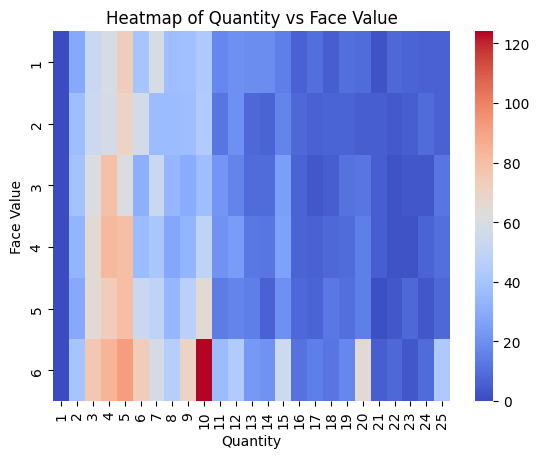




liar valid rate


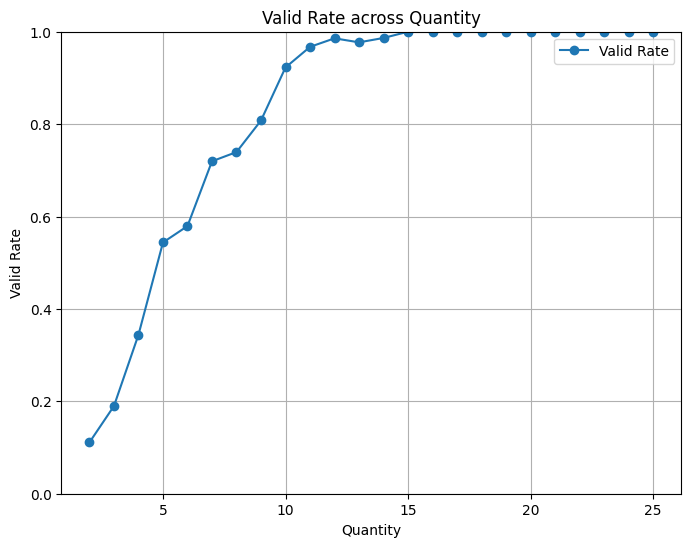

In [17]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### 7. Test for Prefer-Bid Using Conservative Increase Strategy
The Prefer-Bid with Conservative Increase Hypothesis posits that a player who use prefer_bid strategy and increases bid quantity conservatively (e.g., by only adding 1 to the previous quantity per turn instead of random increases) will outperform opponents using random strategies. This strategy focuses on controlled bidding to minimize unnecessary risks while leveraging known dice probabilities.

In [19]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses prefer_bid and conservative_increase strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(prefer_bid =  True, conservative_increase = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4179          16.72%
1           2        4160          16.64%
2           3        4202          16.81%
3           4        4177          16.71%
4           5        4134          16.54%
5           6        4148          16.59%



win rate distribution
    Player  Wins Win Rate
0  player0   359   35.90%
1  player1   157   15.70%
2  player2   156   15.60%
3  player3   150   15.00%
4  player4   178   17.80%



first player distribution
     Player  Start times Start rate
0  player 0          206     20.60%
1  player 1          200     20.00%
2  player 2          202     20.20%
3  player 3          193     19.30%
4  player 4          199     19.90%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
29         5           6    100           40             60
59        10           6     98           93              5
25         5           2     95           41        

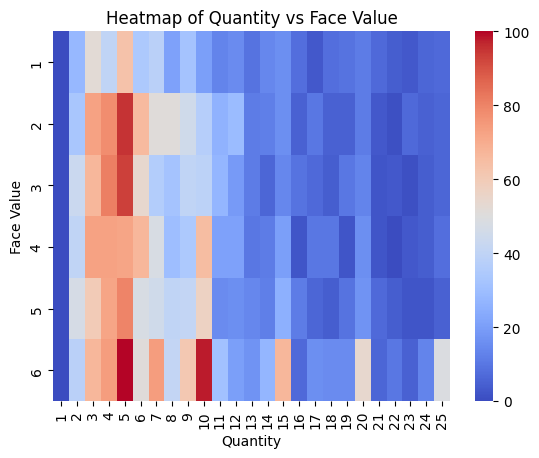




liar valid rate


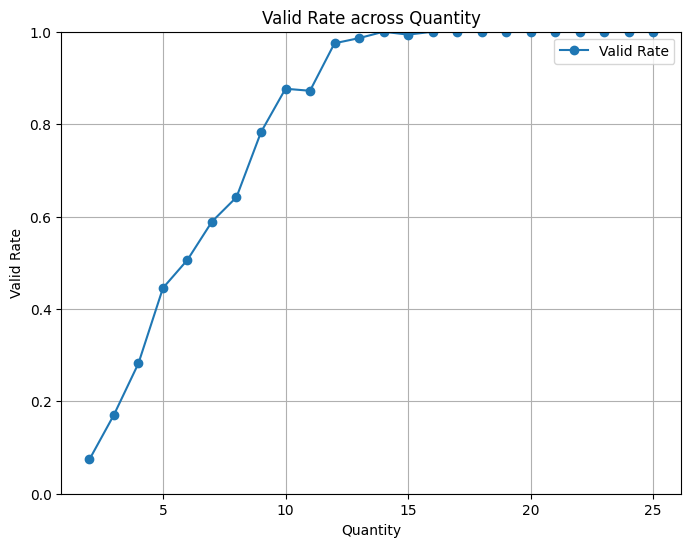

In [20]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### Test for different strtegies


In [21]:
# Simulate the game with 5 players and each player has 5 dice (some players use random strategies and one uses normal_threshold and prefer_bid strategy)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(normal_threshold = True)
    elif i == 1:
        Strategies[i] = stra.Strategy(normal_threshold = True,prefer_bid = True)
    elif i == 2:
        Strategies[i] = stra.Strategy(prefer_bid = True)
    elif i == 3:
        Strategies[i] = stra.Strategy(optimal_threshold = True,prefer_bid = True)
    elif i == 4:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = False)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4240          16.96%
1           2        4098          16.39%
2           3        4143          16.57%
3           4        4185          16.74%
4           5        4152          16.61%
5           6        4182          16.73%



win rate distribution
    Player  Wins Win Rate
0  player0   149   14.90%
1  player1   285   28.50%
2  player2    88    8.80%
3  player3   430   43.00%
4  player4    48    4.80%



first player distribution
     Player  Start times Start rate
0  player 0          193     19.30%
1  player 1          221     22.10%
2  player 2          205     20.50%
3  player 3          188     18.80%
4  player 4          193     19.30%



challenge bid distribution
    quantity  face_value  times  valid_times  invalid_times
55        10           2     92           86              6
49         9           2     87           75             12
37         7           2     77           55        

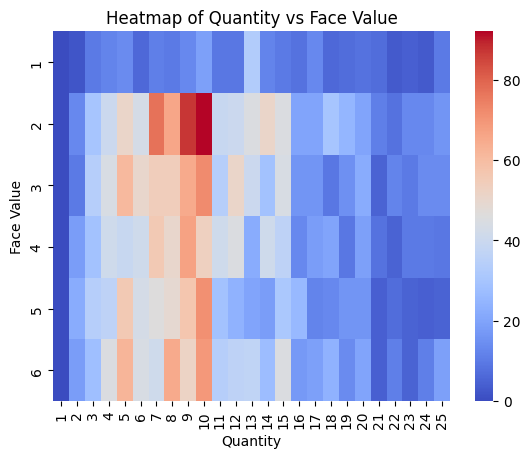




liar valid rate


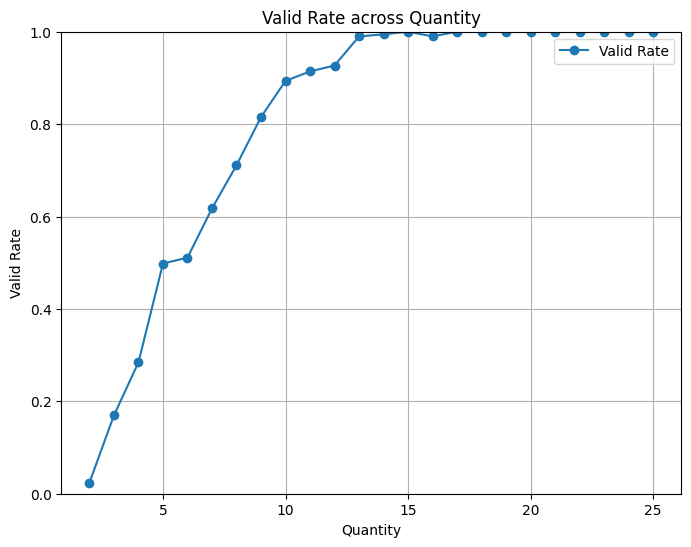

In [22]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### Test hypothesis for special rule

In [23]:
# Simulate the game with 5 players and each player has 5 dice (everyone uses random strategies,but plays under special rule)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
Strategies = {}
for i in range(num_players):
    if i == 0:
        Strategies[i] = stra.Strategy(normal_threshold = True)
    else:
        Strategies[i] = stra.Strategy()
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = (game.simulate_game(num_players, num_dice, Strategies, first_caller = -1, special_rule = True))
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4201          16.80%
1           2        4093          16.37%
2           3        4238          16.95%
3           4        4197          16.79%
4           5        4099          16.40%
5           6        4172          16.69%



win rate distribution
    Player  Wins Win Rate
0  player0   459   45.90%
1  player1   130   13.00%
2  player2   138   13.80%
3  player3   117   11.70%
4  player4   156   15.60%



first player distribution
     Player  Start times Start rate
0  player 0          203     20.30%
1  player 1          201     20.10%
2  player 2          202     20.20%
3  player 3          197     19.70%
4  player 4          197     19.70%



challenge bid distribution
     quantity  face_value  times  valid_times  invalid_times
11          2           6    529          189            340
23          4           6    526          318            208
17          3           6    524          265    

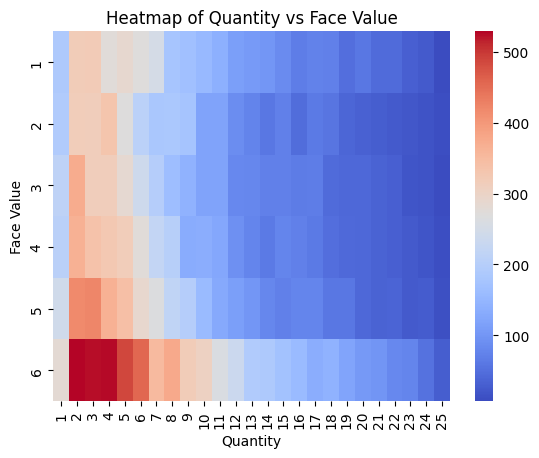




liar valid rate


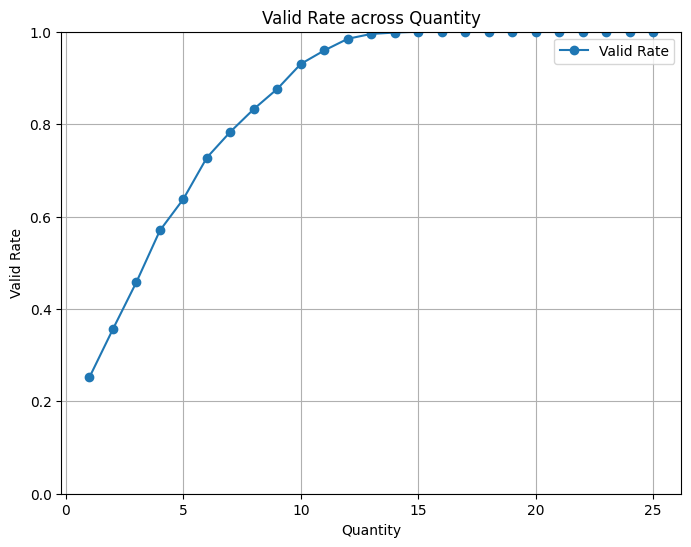

In [24]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()